### Final Project: Music Genre Classification with CNN

### Setup and Imports

In [18]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


### Step 1: Dataset Selection and Loading

**Justification:**

- The GTZAN dataset is a supervised learning dataset with audio files labeled by music genre.
- It contains A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds) and is widely used in music genre classification studies.
- For our project, we plan to compare deep learning models (RNN/CNN) against traditional ML models.

In [19]:
# Function to load and explore the dataset
try:
    data_df = pd.read_csv("features_3_sec.csv")
    print("Dataset loaded successfully!")
except Exception as e:
    print("Error loading dataset:", e)

# Exploration of the dataset
print("\nFirst 5 records:")
print(data_df.head())

Dataset loaded successfully!

First 5 records:
            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.77

In [20]:
# Shape of the dataset
print("\nDataset shape:", data_df.shape)
print("\nStatistical summary:")
print(data_df.describe())


Dataset shape: (9990, 60)

Statistical summary:
        length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9990.0       9990.000000      9990.000000  9990.000000  9.990000e+03   
mean   66149.0          0.379534         0.084876     0.130859  2.676388e-03   
std        0.0          0.090466         0.009637     0.068545  3.585628e-03   
min    66149.0          0.107108         0.015345     0.000953  4.379535e-08   
25%    66149.0          0.315698         0.079833     0.083782  6.145900e-04   
50%    66149.0          0.384741         0.085108     0.121253  1.491318e-03   
75%    66149.0          0.442443         0.091092     0.176328  3.130862e-03   
max    66149.0          0.749481         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9990.000000           9.990000e+03              9990.000000   
mean              2199.219431           4.166727e+05              22

In [21]:
# Data types
print("\nData types:")
print(data_df.dtypes)


Data types:
filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_v

In [22]:
# Distribution of genres
print("\nGenre distribution in the dataset:")
print(data_df['label'].value_counts())


Genre distribution in the dataset:
label
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: count, dtype: int64


### Step 2: Data Cleaning

In [23]:
# Check and handle missing values
print("Missing values by column:")
print(data_df.isnull().sum())

Missing values by column:
filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean       

In [24]:
# Detect and remove outliers function using IQR method on numeric columns
def detect_outliers_iqr(data_df, column):
    """
    Detect outliers in a specified column using the IQR method.
    Returns a DataFrame containing only the outlier rows.
    """
    Q1 = data_df[column].quantile(0.25)
    Q3 = data_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data_df[(data_df[column] < lower_bound) | (data_df[column] > upper_bound)]
    return outliers

def remove_outliers_iqr(data_df, column):
    """
    Removes outliers in the specified column using the IQR method.

    Returns:
        A new DataFrame with outlier rows removed.
    """
    Q1 = data_df[column].quantile(0.25)
    Q3 = data_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Create a mask that keeps only values within the bounds.
    mask = (data_df[column] >= lower_bound) & (data_df[column] <= upper_bound)
    df_clean = data_df[mask].copy()
    return df_clean

In [25]:
# Visualize numeric columns for outliers
numeric_cols = data_df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns to check for outliers:", numeric_cols)


Numeric columns to check for outliers: ['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var']


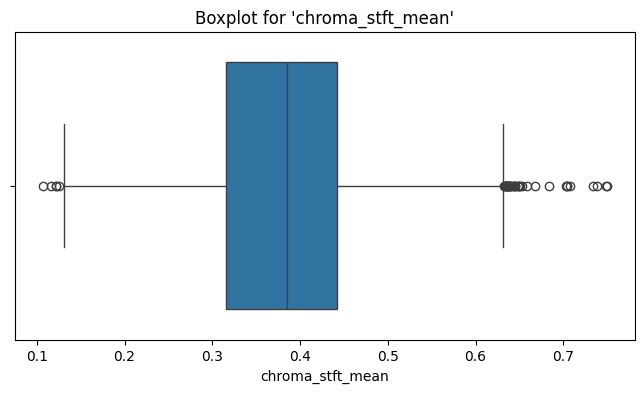

Detected 39 outlier(s) in 'chroma_stft_mean' using IQR method.


In [26]:
# Visualizing outliers for "chroma_stft_mean"
if 'chroma_stft_mean' in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=data_df['chroma_stft_mean'])
    plt.title("Boxplot for 'chroma_stft_mean'")
    plt.xlabel("chroma_stft_mean")
    plt.show()

    # Detect outliers for "chroma_stft_mean"
    outliers_chroma = detect_outliers_iqr(data_df, 'chroma_stft_mean')
    print(f"Detected {len(outliers_chroma)} outlier(s) in 'chroma_stft_mean' using IQR method.")


In [27]:
 # Remove outliers from the 'chroma_stft_mean' column.
data_df_clean = remove_outliers_iqr(data_df, 'chroma_stft_mean')
print("New shape after removing outliers from 'chroma_stft_mean':", data_df_clean.shape)

New shape after removing outliers from 'chroma_stft_mean': (9951, 60)


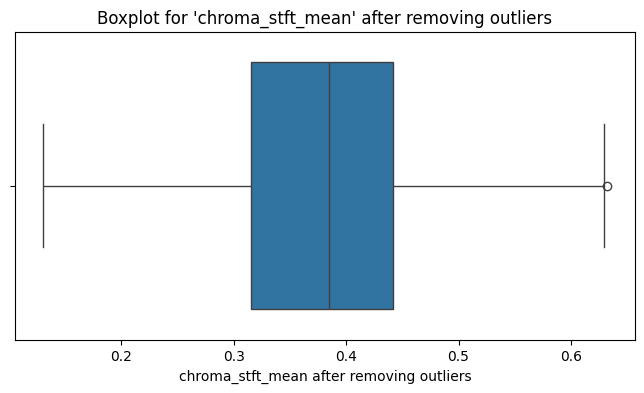

Detected 1 outlier(s) in 'chroma_stft_mean' using IQR method.


In [28]:
# Visualizing after removing outliers for "chroma_stft_mean"
if 'chroma_stft_mean' in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=data_df_clean['chroma_stft_mean'])
    plt.title("Boxplot for 'chroma_stft_mean' after removing outliers")
    plt.xlabel("chroma_stft_mean after removing outliers")
    plt.show()

    outliers_chroma = detect_outliers_iqr(data_df_clean, 'chroma_stft_mean')
    print(f"Detected {len(outliers_chroma)} outlier(s) in 'chroma_stft_mean' using IQR method.")

### Step 3: Data Exploration

In [29]:
# Statistical summaries of the clean dataset after outlier removal
print("\nStatistical summary of the clean dataset:")
print(data_df_clean.describe())


Statistical summary of the clean dataset:
        length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9951.0       9951.000000      9951.000000  9951.000000  9.951000e+03   
mean   66149.0          0.378697         0.085035     0.130743  2.683310e-03   
std        0.0          0.088895         0.009253     0.068147  3.589484e-03   
min    66149.0          0.130597         0.043849     0.001539  1.257168e-07   
25%    66149.0          0.315540         0.079916     0.083859  6.201435e-04   
50%    66149.0          0.384476         0.085150     0.121355  1.496230e-03   
75%    66149.0          0.441795         0.091120     0.176296  3.142374e-03   
max    66149.0          0.631682         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9951.000000           9.951000e+03              9951.000000   
mean              2195.408620           4.174557e+05              2240.748

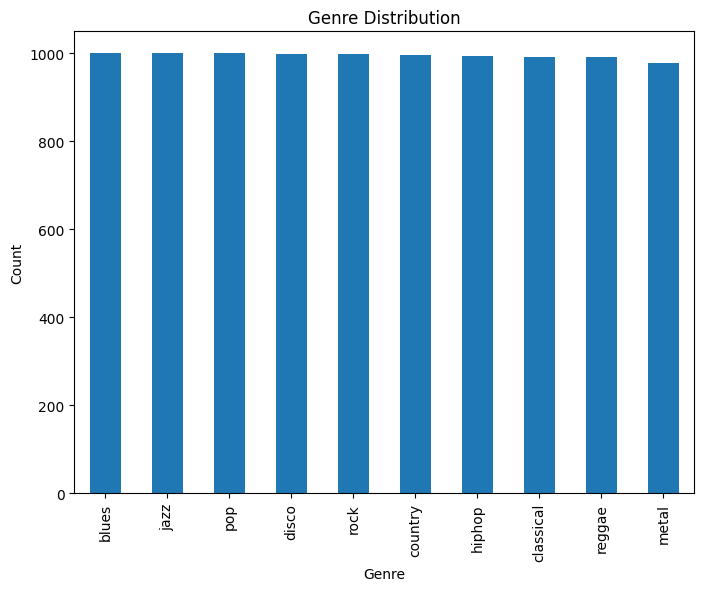

In [30]:
# Visualization: Distribution of genres
plt.figure(figsize=(8,6))
data_df_clean['label'].value_counts().plot(kind='bar')
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

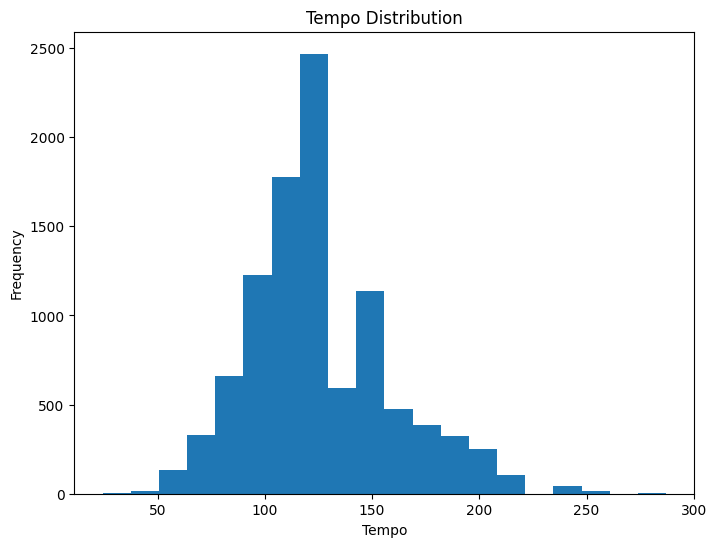

In [31]:
# Visualization: For any specific numeric feature (e.g., 'tempo')
if 'tempo' in data_df_clean.columns:
    plt.figure(figsize=(8,6))
    plt.hist(data_df_clean['tempo'], bins=20)
    plt.title("Tempo Distribution")
    plt.xlabel("Tempo")
    plt.ylabel("Frequency")
    plt.show()

**Loading some samples per genre from the dataset**

Rock   

Classical

### Step 4: Feature Engineering

In [32]:
# Dropping 'filename' column
columns_to_drop = []
if 'filename' in data_df_clean.columns:
    columns_to_drop.append('filename')

In [33]:
if columns_to_drop:
    data_df_clean = data_df.drop(columns=columns_to_drop)
    print(f"\nDropped columns: {columns_to_drop}")
    print("Data shape after dropping columns:", data_df_clean.shape)


Dropped columns: ['filename']
Data shape after dropping columns: (9990, 59)


In [34]:
# Feature extraction:
labels = data_df_clean.iloc[:, -1] # The last column is the label
convertor = LabelEncoder()
y = convertor.fit_transform(labels)
y

array([0, 0, 0, ..., 9, 9, 9])

In [35]:
genres = list(convertor.classes_)
print(genres)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [36]:
# Printing the first 5 labels
print(data_df_clean.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [37]:
# Scaling features

scaler = StandardScaler()
x = scaler.fit_transform(np.array(data_df_clean.iloc[:, :-1], dtype = float))
print("\nFeature matrix shape:", x.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (9990, 58)
Labels shape: (9990,)


## Step 5. Model Selection

In [38]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print("\nTraining feature shape:", x_train.shape)
print("Testing feature shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)



Training feature shape: (6693, 58)
Testing feature shape: (3297, 58)
Training labels shape: (6693,)
Testing labels shape: (3297,)


### Logistic Regression

In [22]:
# Logistic Regression
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(x_train, y_train)
y_pred_logistic_reg = logistic_reg.predict(x_test)

#Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic_reg))
print(classification_report(y_test, y_pred_logistic_reg, target_names=genres))
log_reg_acc = accuracy_score(y_test, logistic_reg.predict(x_test))

Logistic Regression Accuracy: 0.7336973005762815
              precision    recall  f1-score   support

       blues       0.74      0.72      0.73       345
   classical       0.89      0.94      0.92       334
     country       0.64      0.65      0.64       313
       disco       0.66      0.65      0.66       335
      hiphop       0.74      0.70      0.72       340
        jazz       0.78      0.81      0.79       313
       metal       0.82      0.83      0.83       340
         pop       0.76      0.86      0.81       300
      reggae       0.71      0.67      0.69       341
        rock       0.57      0.53      0.55       336

    accuracy                           0.73      3297
   macro avg       0.73      0.74      0.73      3297
weighted avg       0.73      0.73      0.73      3297



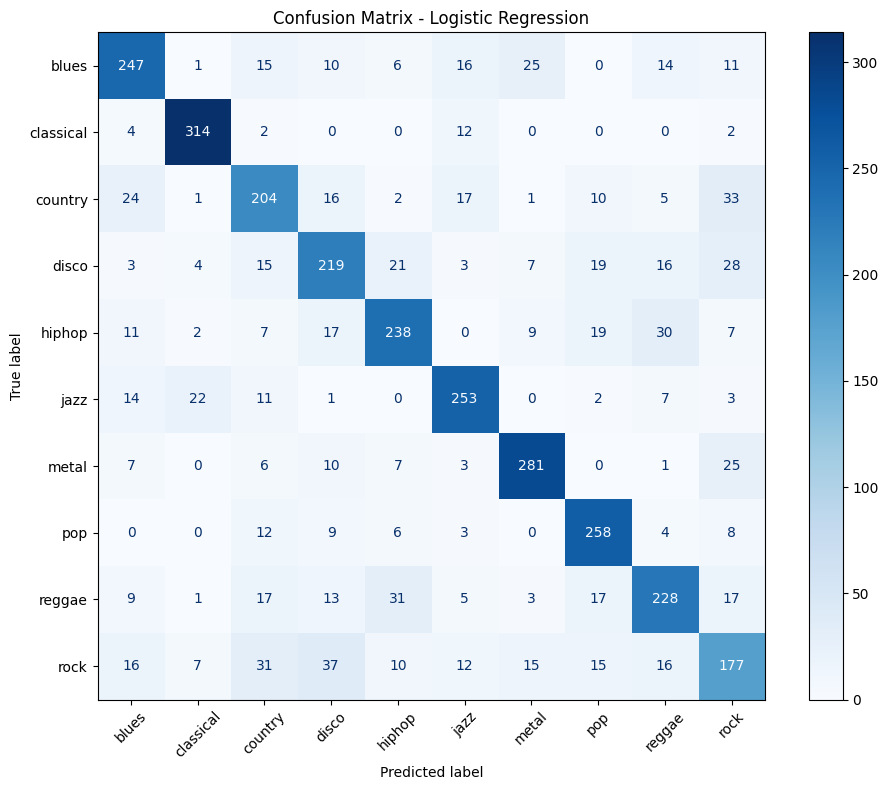

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logistic_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()


### SVM (Support Vector Machine)

In [ ]:
# SVM Model
svm_model = SVC(kernel='rbf', C=10, gamma='scale')
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)

#Evaluation
print("Support Vector Machine Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=genres))
svm_acc = accuracy_score(y_test, svm_model.predict(x_test))

Support Vector Machine Accuracy: 0.9144676979071884
              precision    recall  f1-score   support

       blues       0.91      0.95      0.93       345
   classical       0.91      0.97      0.94       334
     country       0.86      0.84      0.85       313
       disco       0.89      0.90      0.89       335
      hiphop       0.94      0.93      0.93       340
        jazz       0.92      0.92      0.92       313
       metal       0.95      0.96      0.95       340
         pop       0.93      0.94      0.93       300
      reggae       0.92      0.94      0.93       341
        rock       0.91      0.80      0.85       336

    accuracy                           0.91      3297
   macro avg       0.91      0.91      0.91      3297
weighted avg       0.91      0.91      0.91      3297



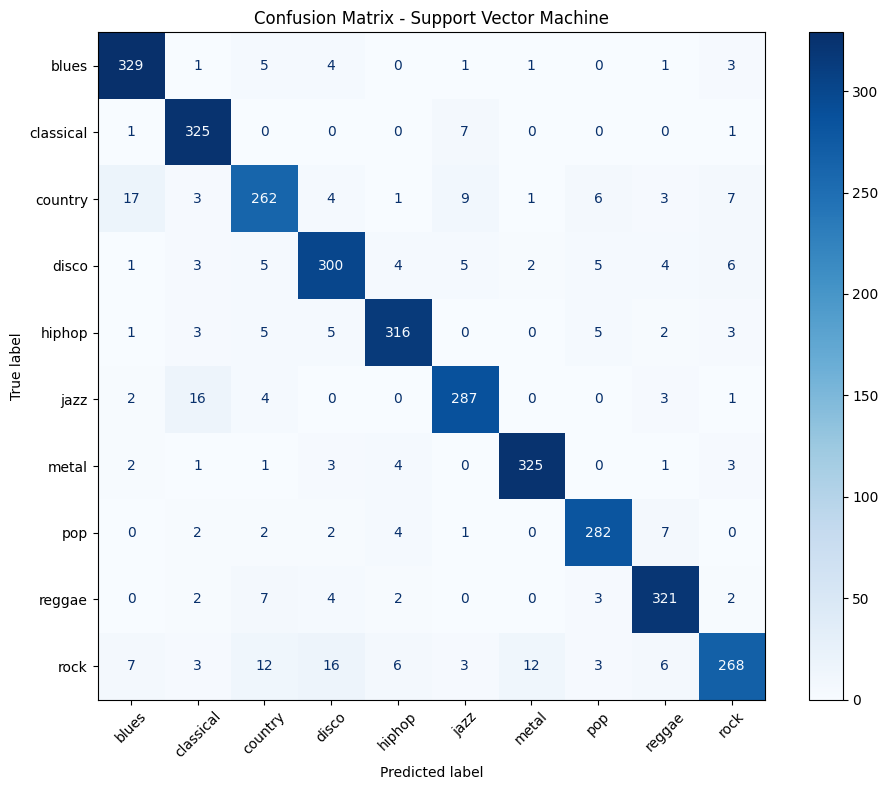

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Support Vector Machine")
plt.tight_layout()
plt.show()

### ANN (Simple Artificial Neural Network)

In [ ]:
# ANN - Artificial Neural Network
model_ann = Sequential([
    Dense(128, input_shape=(x_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # softmax - multiclass
])

# Compile
model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history = model_ann.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

#Evaluation
loss, ann_acc = model_ann.evaluate(x_test, y_test)
print(f"ANN Accuracy: {ann_acc:.4f}")

# Predictions
y_pred_ann = model_ann.predict(x_test)
y_pred_labels = y_pred_ann.argmax(axis=1)


Epoch 1/50
168/168 [==============================] - 4s 8ms/step - loss: 1.7358 - accuracy: 0.3829 - val_loss: 1.2614 - val_accuracy: 0.5743
Epoch 2/50
168/168 [==============================] - 1s 5ms/step - loss: 1.2971 - accuracy: 0.5407 - val_loss: 1.0555 - val_accuracy: 0.6423
Epoch 3/50
168/168 [==============================] - 1s 6ms/step - loss: 1.1333 - accuracy: 0.6068 - val_loss: 0.9441 - val_accuracy: 0.6863
Epoch 4/50
168/168 [==============================] - 1s 4ms/step - loss: 1.0216 - accuracy: 0.6406 - val_loss: 0.8712 - val_accuracy: 0.7147
Epoch 5/50
168/168 [==============================] - 1s 3ms/step - loss: 0.9769 - accuracy: 0.6589 - val_loss: 0.8087 - val_accuracy: 0.7267
Epoch 6/50
168/168 [==============================] - 1s 3ms/step - loss: 0.9131 - accuracy: 0.6890 - val_loss: 0.7694 - val_accuracy: 0.7371
Epoch 7/50
168/168 [==============================] - 1s 3ms/step - loss: 0.8718 - accuracy: 0.6920 - val_loss: 0.7603 - val_accuracy: 0.7476
Epoch 

In [ ]:
# Report
report_dict = classification_report(y_test, y_pred_labels, target_names=genres, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
summary_df = report_df.iloc[:-3]

print(f"Artificial Neural Network Accuracy: {ann_acc}")

# Print classification report
print(classification_report(y_test, y_pred_labels, target_names=genres))

Artificial Neural Network Accuracy: 0.8574461340904236
              precision    recall  f1-score   support

       blues       0.86      0.89      0.88       345
   classical       0.88      0.98      0.93       334
     country       0.84      0.78      0.81       313
       disco       0.78      0.83      0.81       335
      hiphop       0.89      0.84      0.86       340
        jazz       0.90      0.84      0.87       313
       metal       0.95      0.92      0.93       340
         pop       0.88      0.89      0.89       300
      reggae       0.82      0.86      0.84       341
        rock       0.79      0.73      0.76       336

    accuracy                           0.86      3297
   macro avg       0.86      0.86      0.86      3297
weighted avg       0.86      0.86      0.86      3297



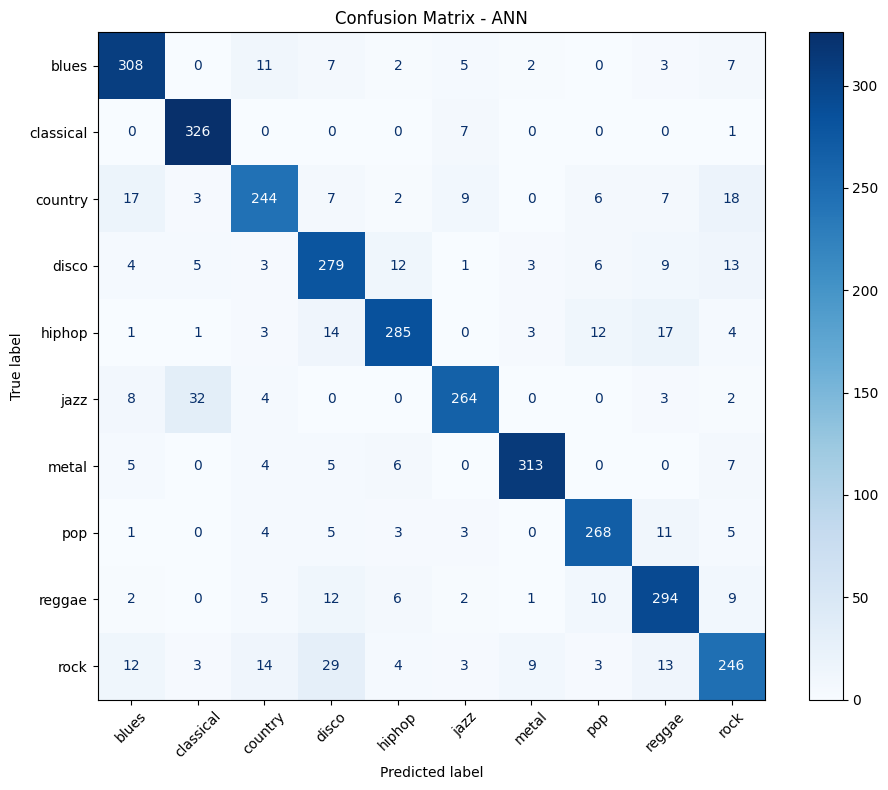

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - ANN")
plt.tight_layout()
plt.show()

### Decision tree Model


 Classification Report (Training Set - Decision Tree):
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       655
   classical       1.00      1.00      1.00       664
     country       1.00      1.00      1.00       684
       disco       1.00      1.00      1.00       664
      hiphop       1.00      1.00      1.00       658
        jazz       1.00      1.00      1.00       687
       metal       0.99      1.00      1.00       660
         pop       1.00      1.00      1.00       700
      reggae       1.00      1.00      1.00       659
        rock       1.00      0.99      1.00       662

    accuracy                           1.00      6693
   macro avg       1.00      1.00      1.00      6693
weighted avg       1.00      1.00      1.00      6693



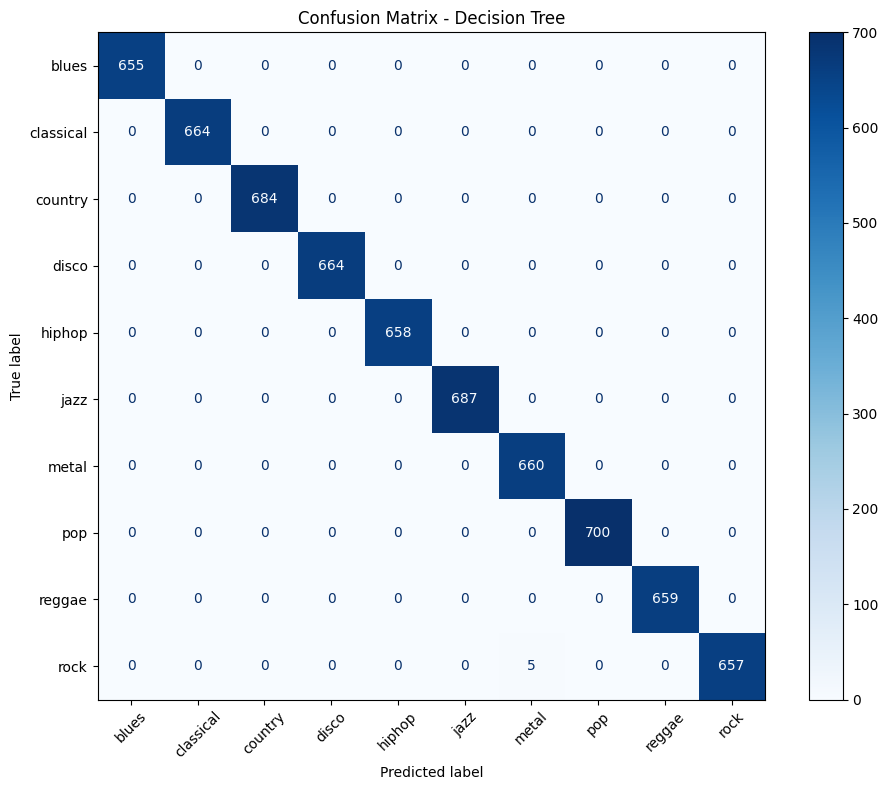


 Classification Report (Test Set - Decision Tree):
              precision    recall  f1-score   support

       blues       0.64      0.56      0.60       345
   classical       0.85      0.82      0.83       334
     country       0.48      0.49      0.49       313
       disco       0.58      0.56      0.57       335
      hiphop       0.65      0.68      0.66       340
        jazz       0.62      0.70      0.66       313
       metal       0.76      0.78      0.77       340
         pop       0.73      0.77      0.75       300
      reggae       0.61      0.60      0.60       341
        rock       0.50      0.49      0.49       336

    accuracy                           0.64      3297
   macro avg       0.64      0.64      0.64      3297
weighted avg       0.64      0.64      0.64      3297



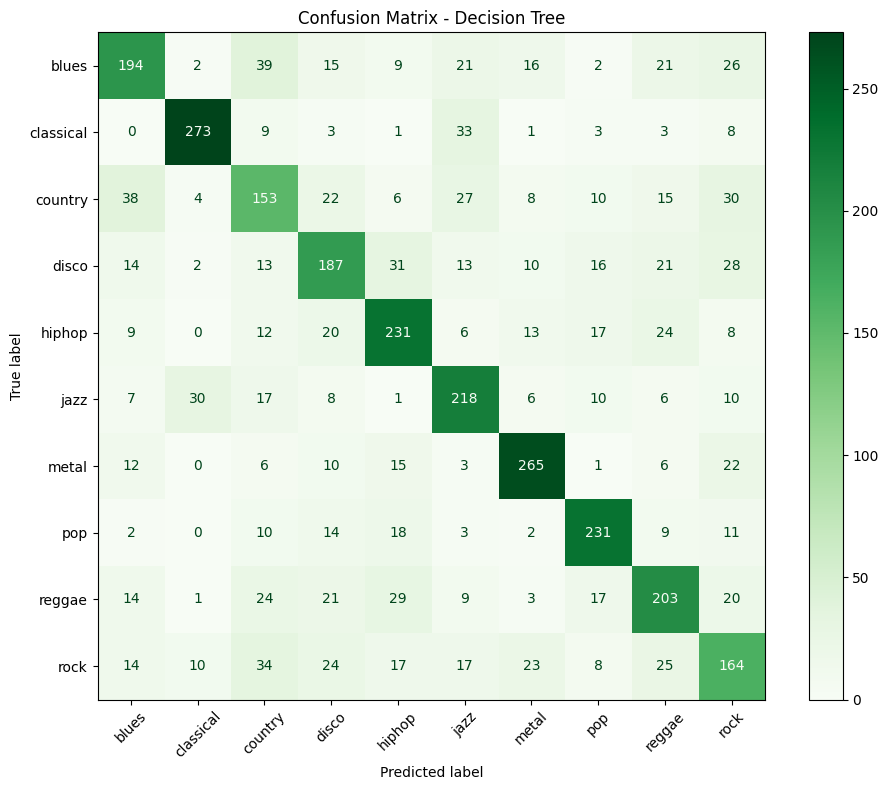

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Build pipeline with Decision Tree
pipe = Pipeline([
    ('model', DecisionTreeClassifier(random_state=42))
])

# Train the model
pipe.fit(x_train, y_train)

# Evaluation on TRAINING set
y_train_pred = pipe.predict(x_train)

print("\n Classification Report (Training Set - Decision Tree):")
print(classification_report(y_train, y_train_pred, target_names= genres))

cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Decision Tree")
plt.tight_layout()
plt.show()

# Evaluation on TEST set
y_test_pred = pipe.predict(x_test)

print("\n Classification Report (Test Set - Decision Tree):")
print(classification_report(y_test, y_test_pred, target_names=genres))

cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - Decision Tree")
plt.tight_layout()
plt.show()


### Radom Forest Model


 Classification Report (Training Set):
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       655
   classical       1.00      1.00      1.00       664
     country       1.00      1.00      1.00       684
       disco       1.00      1.00      1.00       664
      hiphop       1.00      1.00      1.00       658
        jazz       1.00      1.00      1.00       687
       metal       0.99      1.00      1.00       660
         pop       1.00      1.00      1.00       700
      reggae       1.00      1.00      1.00       659
        rock       1.00      0.99      1.00       662

    accuracy                           1.00      6693
   macro avg       1.00      1.00      1.00      6693
weighted avg       1.00      1.00      1.00      6693



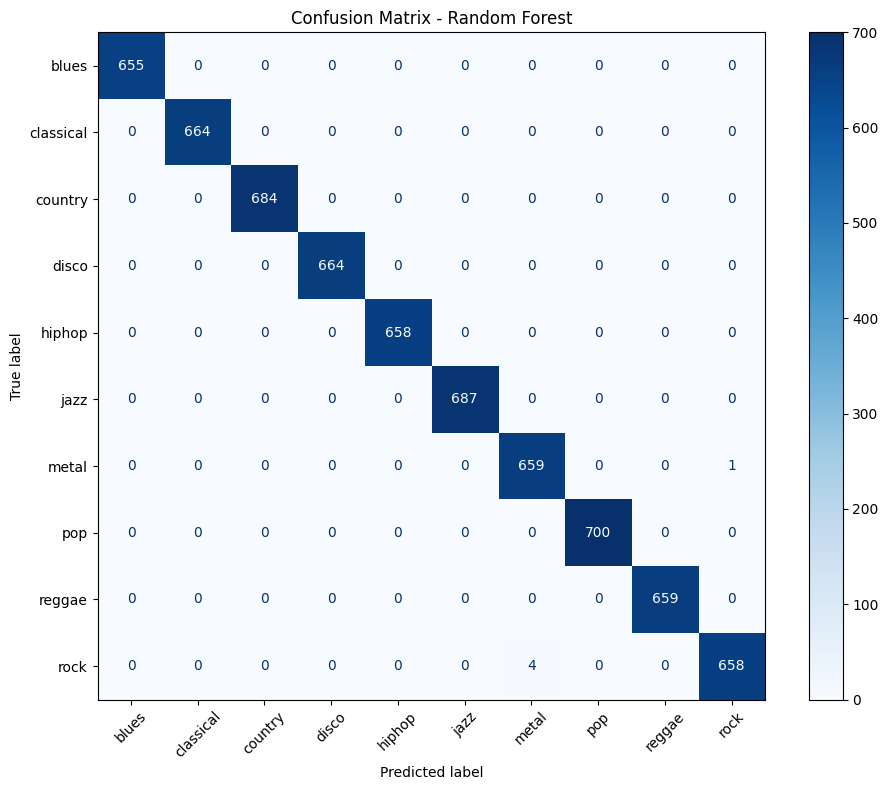


 Classification Report (Test Set):
              precision    recall  f1-score   support

       blues       0.88      0.82      0.85       345
   classical       0.90      0.96      0.93       334
     country       0.76      0.80      0.78       313
       disco       0.85      0.83      0.84       335
      hiphop       0.89      0.84      0.87       340
        jazz       0.79      0.89      0.84       313
       metal       0.90      0.95      0.92       340
         pop       0.86      0.91      0.89       300
      reggae       0.87      0.87      0.87       341
        rock       0.86      0.71      0.78       336

    accuracy                           0.86      3297
   macro avg       0.86      0.86      0.86      3297
weighted avg       0.86      0.86      0.86      3297



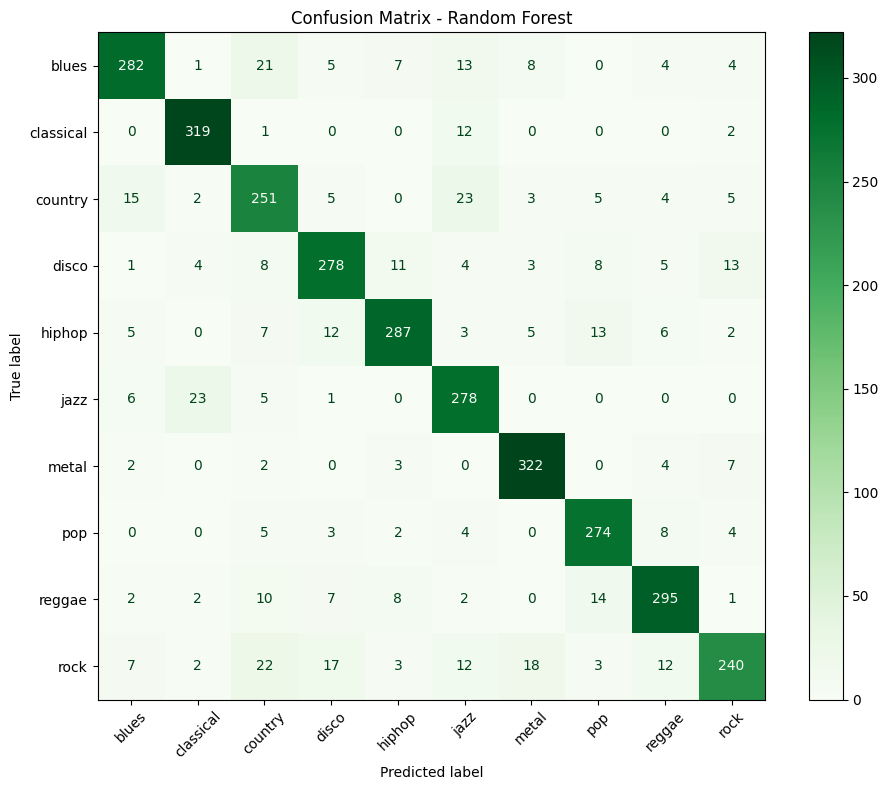

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Build pipeline
pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# Fit model
pipe.fit(x_train, y_train)

#  Evaluation on TRAINING set
y_train_pred = pipe.predict(x_train)

print("\n Classification Report (Training Set):")
print(classification_report(y_train, y_train_pred, target_names=genres))

cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

#  Evaluation on TEST set
y_test_pred = pipe.predict(x_test)

print("\n Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=genres))

cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()


### RNN (Recurrent Neural Network)

 #### Prepare your dataset as sequences

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

c:\Users\oscar\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\oscar\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1


In [2]:
import os
import librosa
import numpy as np

def extract_mfcc_sequence_from_segment(y_segment, sr, n_mfcc=20, max_len=130):
    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=n_mfcc)

    # Pad or trim to fixed length
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc.T  # shape: (max_len, n_mfcc)

def build_segmented_dataset(base_dir, segment_duration=3, n_mfcc=20, max_len=130):
    X = []
    y = []

    for genre in os.listdir(base_dir):
        genre_path = os.path.join(base_dir, genre)
        if not os.path.isdir(genre_path): continue

        for file in os.listdir(genre_path):
            if not file.endswith(".wav"):
                continue

            file_path = os.path.join(genre_path, file)
            try:
                y_audio, sr = librosa.load(file_path, sr=None)
                y_audio, _ = librosa.effects.trim(y_audio)

                samples_per_segment = int(segment_duration * sr)
                num_segments = len(y_audio) // samples_per_segment

                for i in range(num_segments):
                    start = i * samples_per_segment
                    end = start + samples_per_segment
                    segment = y_audio[start:end]

                    if len(segment) == samples_per_segment:
                        mfcc_seq = extract_mfcc_sequence_from_segment(segment, sr, n_mfcc, max_len)
                        X.append(mfcc_seq)
                        y.append(genre)

            except Exception as e:
                print(f" Skipping {file_path}: {e}")

    return np.array(X), np.array(y)


In [45]:
base_dir = f"{path}\\Data\\genres_original"

X, y = build_segmented_dataset(base_dir)

print("X shape:", X.shape)  # Expected: (num_segments, 130, 20)
print("y shape:", y.shape)  # Expected: (num_segments,)

C:\Users\oscar\AppData\Local\Temp\ipykernel_3436\158984778.py:31: UserWarning: PySoundFile failed. Trying audioread instead.
  y_audio, sr = librosa.load(file_path, sr=None)
c:\Users\oscar\anaconda3\envs\py310\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Skipping C:\Users\oscar\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1\Data\genres_original\jazz\jazz.00054.wav: 
X shape: (9980, 130, 20)
y shape: (9980,)


In [46]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization

model = Sequential([
    Masking(mask_value=0., input_shape=(130, 20)),

    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),  # Optional here
    Dropout(0.3),

    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print('Training feature shape:',X_train.shape)
print("Testing feature shape:",X_test.shape)
print("Training labels shape:",y_train.shape)
print("Testing labels shape:",y_test.shape)

Training feature shape: (7984, 130, 20)
Testing feature shape: (1996, 130, 20)
Training labels shape: (7984, 10)
Testing labels shape: (1996, 10)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
250/250 [==============================] - 24s 43ms/step - loss: 2.1248 - accuracy: 0.3027 - val_loss: 1.4884 - val_accuracy: 0.4760
Epoch 2/100
250/250 [==============================] - 8s 33ms/step - loss: 1.6362 - accuracy: 0.4294 - val_loss: 1.2934 - val_accuracy: 0.5281
Epoch 3/100
250/250 [==============================] - 8s 32ms/step - loss: 1.4555 - accuracy: 0.4772 - val_loss: 1.1922 - val_accuracy: 0.5541
Epoch 4/100
250/250 [==============================] - 8s 32ms/step - loss: 1.3270 - accuracy: 0.5292 - val_loss: 1.1235 - val_accuracy: 0.6012
Epoch 5/100
250/250 [==============================] - 8s 33ms/step - loss: 1.2745 - accuracy: 0.5498 - val_loss: 1.0800 - val_accuracy: 0.6122
Epoch 6/100
250/250 [==============================] - 8s 32ms/step - loss: 1.1719 - accuracy: 0.5934 - val_loss: 1.0177 - val_accuracy: 0.6433
Epoch 7/100
250/250 [==============================] - 8s 32ms/step - loss: 1.1070 - accuracy: 0.6176 - val_loss: 1.0800 - val_accuracy

In [8]:
#Evaluate test performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {test_acc:.4f}")
print(f" Final Test Loss: {test_loss:.4f}")

63/63 [==============================] - 1s 15ms/step - loss: 0.4619 - accuracy: 0.8768
 Final Test Accuracy: 0.8768
 Final Test Loss: 0.4619


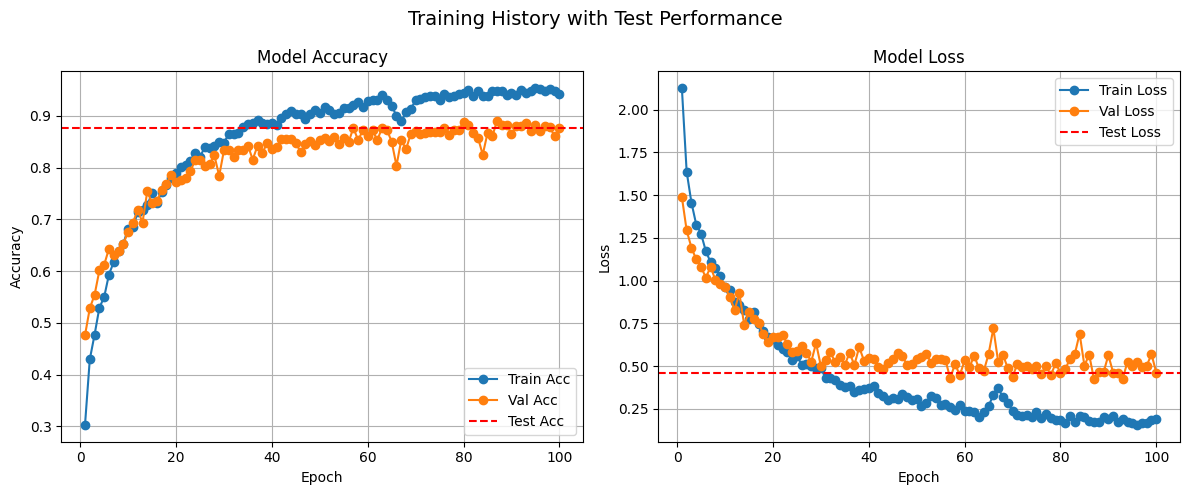

In [11]:

#Plot training history with test performance
def plot_training_history_with_test(history, test_loss=None, test_acc=None):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Acc', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Acc', marker='o')
    if test_acc is not None:
        plt.axhline(y=test_acc, color='red', linestyle='--', label='Test Acc')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss', marker='o')
    if test_loss is not None:
        plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.suptitle("Training History with Test Performance", fontsize=14)
    plt.tight_layout()
    plt.show()

# 6. Call the plot function
plot_training_history_with_test(history, test_loss=test_loss, test_acc=test_acc)

### CNN (Convolutional Neural Network)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, num_classes):
    model = Sequential()

    # 1st conv block
    model.add(Conv2D(32, (2, 2), activation='relu', input_shape=input_shape, kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 2nd conv block
    model.add(Conv2D(64, (2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 3rd conv block
    model.add(Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [49]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# CNN expects 4D input: (samples, height, width, channels)
X_cnn = X[..., np.newaxis]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_onehot, test_size=0.2, random_state=42)

# Build and train the model
input_shape = X_train.shape[1:]  # (timesteps, features, 1)
num_classes = y_onehot.shape[1]

model = build_model(input_shape, num_classes)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test))


Epoch 1/100
250/250 [==============================] - 2s 7ms/step - loss: 1.8597 - accuracy: 0.3498 - val_loss: 1.6547 - val_accuracy: 0.4153
Epoch 2/100
250/250 [==============================] - 2s 6ms/step - loss: 1.4580 - accuracy: 0.4788 - val_loss: 1.1286 - val_accuracy: 0.5942
Epoch 3/100
250/250 [==============================] - 2s 6ms/step - loss: 1.2116 - accuracy: 0.5744 - val_loss: 1.0486 - val_accuracy: 0.6363
Epoch 4/100
250/250 [==============================] - 1s 6ms/step - loss: 1.0686 - accuracy: 0.6298 - val_loss: 1.0999 - val_accuracy: 0.6102
Epoch 5/100
250/250 [==============================] - 2s 6ms/step - loss: 0.9192 - accuracy: 0.6810 - val_loss: 0.9447 - val_accuracy: 0.6708
Epoch 6/100
250/250 [==============================] - 2s 7ms/step - loss: 0.8103 - accuracy: 0.7239 - val_loss: 1.0221 - val_accuracy: 0.6473
Epoch 7/100
250/250 [==============================] - 2s 6ms/step - loss: 0.7217 - accuracy: 0.7530 - val_loss: 0.8734 - val_accuracy: 0.7079

In [14]:
# Evaluate test performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {test_acc:.4f}")
print(f" Final Test Loss: {test_loss:.4f}")

63/63 [==============================] - 0s 3ms/step - loss: 1.4981 - accuracy: 0.7580
 Final Test Accuracy: 0.7580
 Final Test Loss: 1.4981


63/63 [==============================] - 0s 3ms/step - loss: 1.4981 - accuracy: 0.7580


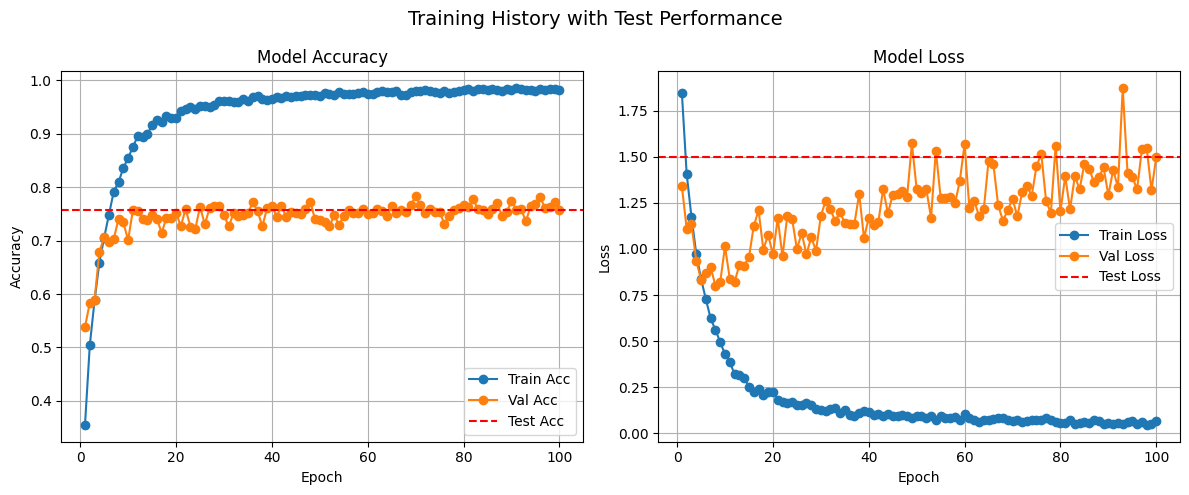

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
plot_training_history_with_test(history, test_loss, test_acc)


### Step 6: Hyperparameter Tuning

#### Logistic Regresion
Logistic Regression with Hyperparameter Tuning
To enhance the predictive performance and generalization ability of the logistic regression model, we conducted hyperparameter tuning using GridSearchCV. The goal was to systematically explore different regularization strategies and their respective parameter configurations.

We considered three types of regularization:

- L2 Regularization (Ridge): Controls model complexity by penalizing the squared magnitude of coefficients.

- L1 Regularization (Lasso): Promotes sparsity by shrinking some coefficients to zero.

- ElasticNet Regularization: Combines both L1 and L2 penalties, offering a flexible compromise between coefficient shrinkage and sparsity.

Each regularization type was paired with a compatible solver:

- lbfgs and saga for L2,

- liblinear and saga for L1,

- saga exclusively for ElasticNet.

The hyperparameter grids included variations of the regularization strength parameter C (0.01, 0.1, 1, 10), and in the case of ElasticNet, the l1_ratio was tuned over 0.25, 0.5, and 0.75.

A 5-fold cross-validation strategy was applied to evaluate each model configuration on the training set. The best-performing model from each grid search was then assessed on the test set using accuracy and detailed classification metrics.

This comprehensive tuning process enabled the selection of the most appropriate regularization method and parameter values for our logistic regression model, contributing to improved model robustness and interpretability.



In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# 1. L2 Regularization
param_grid_l2 = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]
}

# 2. L1 Regularization
param_grid_l1 = {
    'penalty': ['l1'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

# 3. ElasticNet Regularization
param_grid_elasticnet = {
    'penalty': ['elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': [1000]
}

# Function to run grid search and evaluate
def run_logistic_tuning(param_grid, label):
    print(f"\n--- {label} ---")
    grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(x_test)

    print("Best Parameters:", grid.best_params_)
    print("Best Cross-Validated Accuracy:", grid.best_score_)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=genres))

    return accuracy_score(y_test, y_pred), grid.best_params_

# Run for each penalty type
acc_l2, best_l2 = run_logistic_tuning(param_grid_l2, "Logistic Regression with L2")
acc_l1, best_l1 = run_logistic_tuning(param_grid_l1, "Logistic Regression with L1")
acc_elasticnet, best_elasticnet = run_logistic_tuning(param_grid_elasticnet, "Logistic Regression with ElasticNet")



--- Logistic Regression with L2 ---
Best Parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validated Accuracy: 0.7138803582532086
Test Accuracy: 0.7355171367910222
              precision    recall  f1-score   support

       blues       0.74      0.73      0.73       345
   classical       0.90      0.94      0.92       334
     country       0.65      0.65      0.65       313
       disco       0.66      0.65      0.65       335
      hiphop       0.73      0.70      0.71       340
        jazz       0.78      0.82      0.80       313
       metal       0.85      0.83      0.84       340
         pop       0.76      0.86      0.81       300
      reggae       0.70      0.66      0.68       341
        rock       0.56      0.53      0.55       336

    accuracy                           0.74      3297
   macro avg       0.73      0.74      0.73      3297
weighted avg       0.73      0.74      0.73      3297


--- Logistic Regression with L1 ---


c:\Users\oscar\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validated Accuracy: 0.713730323256206
Test Accuracy: 0.7352138307552321
              precision    recall  f1-score   support

       blues       0.74      0.72      0.73       345
   classical       0.89      0.94      0.92       334
     country       0.64      0.65      0.65       313
       disco       0.66      0.64      0.65       335
      hiphop       0.74      0.70      0.72       340
        jazz       0.79      0.82      0.80       313
       metal       0.83      0.83      0.83       340
         pop       0.76      0.86      0.81       300
      reggae       0.71      0.67      0.69       341
        rock       0.57      0.53      0.55       336

    accuracy                           0.74      3297
   macro avg       0.73      0.74      0.73      3297
weighted avg       0.73      0.74      0.73      3297


--- Logistic Regression with ElasticNet ---
Best Parameters: {'C': 1, 'l1_rati

c:\Users\oscar\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### SMV
Support Vector Machine with Hyperparameter Tuning
To optimize the performance of the Support Vector Machine (SVM) classifier, we conducted a grid search over key hyperparameters. Specifically, we tuned the following:

- C: The regularization parameter, which controls the trade-off between achieving a low training error and a low testing error (model generalization).

- gamma: The kernel coefficient for the radial basis function (RBF) kernel. Lower values imply a broader influence of individual training points, while higher values lead to tighter, more complex decision boundaries.

- kernel: We focused on the RBF kernel due to its effectiveness in capturing non-linear patterns in high-dimensional spaces.

We applied GridSearchCV with 5-fold cross-validation to evaluate various combinations of these parameters. The best model was selected based on cross-validated accuracy and then evaluated on the test set. This tuning process allowed us to systematically improve the model’s ability to generalize to unseen data, as reflected by enhanced performance metrics.

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define hyperparameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],             # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf']                  # You can add 'linear', 'poly' or 'sigmoid' if desired
}

# GridSearchCV for SVM
grid_svm = GridSearchCV(SVC(), param_grid=param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(x_train, y_train)

# Best model
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(x_test)

# Evaluation
print("Best Parameters (SVM):", grid_svm.best_params_)
print("Best Cross-Validated Accuracy:", grid_svm.best_score_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=genres))

svm_acc = accuracy_score(y_test, y_pred_svm)


Best Parameters (SVM): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validated Accuracy: 0.8909300272050066
Test Accuracy: 0.9144676979071884
              precision    recall  f1-score   support

       blues       0.91      0.95      0.93       345
   classical       0.91      0.97      0.94       334
     country       0.86      0.84      0.85       313
       disco       0.89      0.90      0.89       335
      hiphop       0.94      0.93      0.93       340
        jazz       0.92      0.92      0.92       313
       metal       0.95      0.96      0.95       340
         pop       0.93      0.94      0.93       300
      reggae       0.92      0.94      0.93       341
        rock       0.91      0.80      0.85       336

    accuracy                           0.91      3297
   macro avg       0.91      0.91      0.91      3297
weighted avg       0.91      0.91      0.91      3297



#### ANN
In this experiment, we tuned the architecture and training parameters of a feedforward artificial neural network (ANN) implemented with Keras. The tuning was performed via GridSearchCV using scikeras.wrappers.KerasClassifier, which allows integration of Keras models into scikit-learn workflows.

The parameters tuned include:

- Hidden Layer Sizes: Varying the number of neurons in each of the two hidden layers.

- Dropout Rate: To regularize the network and mitigate overfitting.

- Learning Rate: To control the update size during optimization with Adam.

- Batch Size and Epochs: Affect convergence speed and stability.

The best model was selected based on cross-validated accuracy across a 3-fold split. This method ensures robust generalization and leverages the power of deep learning while maintaining a reproducible evaluation framework.

In [42]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

# Make a function that builds and returns a compiled keras model
def create_model(meta, hidden1=128, hidden2=64, dropout_rate=0.3, learning_rate=0.001):
    # This function signature is important - include 'meta' parameter
    input_shape = meta["X_shape_"][1:]  # Get input shape from meta
    n_classes = meta["n_classes_"]  # Get number of classes from meta

    model = Sequential()
    model.add(Dense(hidden1, activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the KerasClassifier with the updated API
ann = KerasClassifier(
    model=create_model,
    hidden1=128,
    hidden2=64,
    dropout_rate=0.3,
    learning_rate=0.001,
    epochs=30,
    batch_size=32,
    verbose=0,
    random_state=42
)

# Parameter grid - note the different parameter naming convention
param_grid = {
    "hidden1": [128, 256],
    "hidden2": [64, 128],
    "dropout_rate": [0.2, 0.3],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [30]
}

# Reduce n_jobs to avoid memory issues
grid_ann = GridSearchCV(
    estimator=ann,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=2  # Start with 1 and increase if your system can handle it
)

# Fit the grid search
grid_ann.fit(x_train, y_train)

# Print results
print("Best Parameters:", grid_ann.best_params_)
print("Best CV Accuracy:", grid_ann.best_score_)

# Evaluate on test set
best_ann_model = grid_ann.best_estimator_
ann_acc = best_ann_model.score(x_test, y_test)
print(f"Test Accuracy: {ann_acc:.4f}")


AttributeError: 'super' object has no attribute '__sklearn_tags__'

#### Desicion Tree
To optimize the performance of the decision tree classifier, we implemented a grid search on key hyperparameters: criterion, max_depth, min_samples_split, and min_samples_leaf. These parameters control the tree's growth, helping to reduce overfitting and improve generalization.


Classification Report (Training Set - Decision Tree):
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       655
   classical       1.00      1.00      1.00       664
     country       1.00      1.00      1.00       684
       disco       1.00      1.00      1.00       664
      hiphop       1.00      1.00      1.00       658
        jazz       1.00      1.00      1.00       687
       metal       0.99      1.00      1.00       660
         pop       1.00      1.00      1.00       700
      reggae       1.00      1.00      1.00       659
        rock       1.00      0.99      1.00       662

    accuracy                           1.00      6693
   macro avg       1.00      1.00      1.00      6693
weighted avg       1.00      1.00      1.00      6693



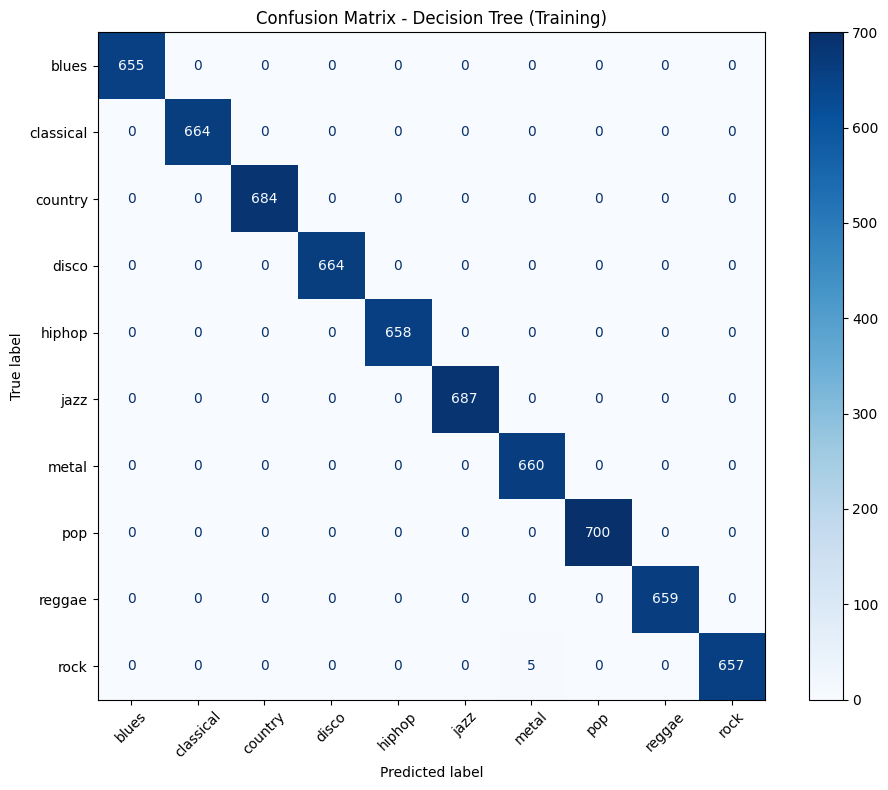


Classification Report (Test Set - Decision Tree):
Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
              precision    recall  f1-score   support

       blues       0.63      0.58      0.60       345
   classical       0.87      0.87      0.87       334
     country       0.50      0.55      0.52       313
       disco       0.59      0.56      0.57       335
      hiphop       0.67      0.66      0.67       340
        jazz       0.65      0.75      0.70       313
       metal       0.81      0.74      0.77       340
         pop       0.70      0.72      0.71       300
      reggae       0.64      0.66      0.65       341
        rock       0.51      0.50      0.50       336

    accuracy                           0.66      3297
   macro avg       0.66      0.66      0.66      3297
weighted avg       0.66      0.66      0.66      3297



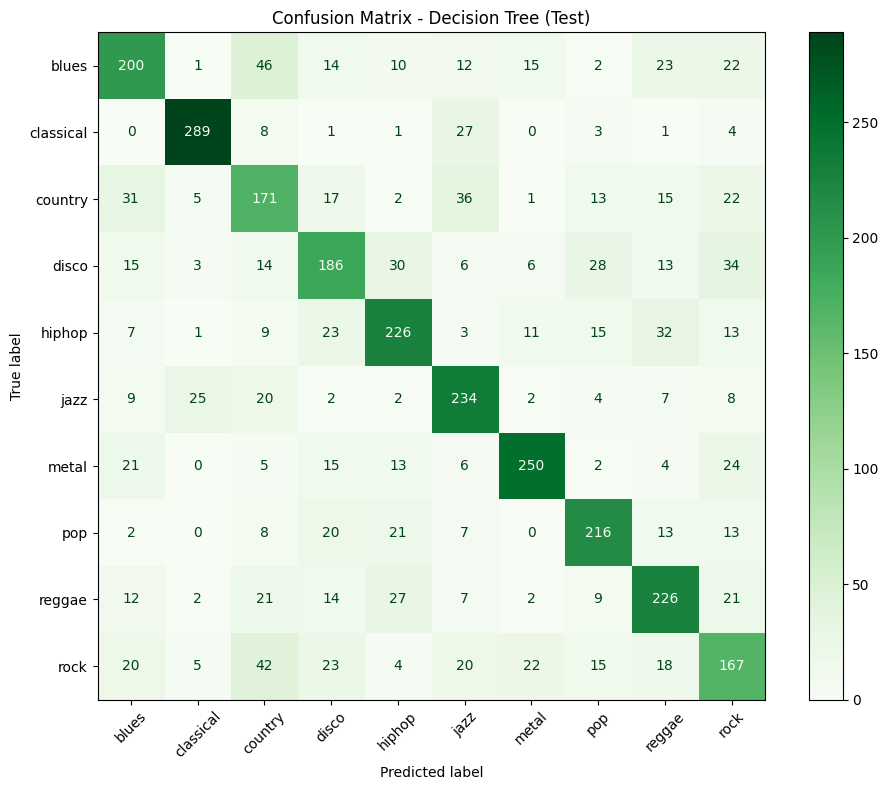

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Si tus datos lo requieren
    ('model', DecisionTreeClassifier(random_state=42))
])

# Hyperparameter grid for Decision Tree
param_grid_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_dt = GridSearchCV(pipe, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(x_train, y_train)

# Best model
best_dt = grid_dt.best_estimator_
y_train_pred = best_dt.predict(x_train)
y_test_pred = best_dt.predict(x_test)

# --- Evaluation on TRAINING set ---
print("\nClassification Report (Training Set - Decision Tree):")
print(classification_report(y_train, y_train_pred, target_names=genres))

cm_train = confusion_matrix(y_train, y_train_pred)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=genres).plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Decision Tree (Training)")
plt.tight_layout()
plt.show()

# --- Evaluation on TEST set ---
print("\nClassification Report (Test Set - Decision Tree):")
print("Best Parameters:", grid_dt.best_params_)
print(classification_report(y_test, y_test_pred, target_names=genres))

cm_test = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=genres).plot(ax=ax, cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - Decision Tree (Test)")
plt.tight_layout()
plt.show()


#### Random Forest
To improve the generalization performance of the Random Forest classifier, we applied GridSearchCV to explore various combinations of key hyperparameters:

- n_estimators: The number of trees in the forest. A higher value generally improves performance but increases computation time.

- max_depth: Controls the depth of each tree. Restricting it can reduce overfitting.

- min_samples_split: Minimum number of samples required to split an internal node.

- min_samples_leaf: Minimum number of samples required to be at a leaf node, which helps control overfitting on noisy data.

The tuning process involved 5-fold cross-validation on the training set and evaluated performance using classification metrics and confusion matrices for both training and test sets. The final model was selected based on the best cross-validated accuracy and was then evaluated on unseen data.


Classification Report (Training Set - Random Forest):
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       655
   classical       1.00      1.00      1.00       664
     country       1.00      1.00      1.00       684
       disco       1.00      1.00      1.00       664
      hiphop       1.00      1.00      1.00       658
        jazz       1.00      1.00      1.00       687
       metal       1.00      1.00      1.00       660
         pop       1.00      1.00      1.00       700
      reggae       1.00      1.00      1.00       659
        rock       1.00      1.00      1.00       662

    accuracy                           1.00      6693
   macro avg       1.00      1.00      1.00      6693
weighted avg       1.00      1.00      1.00      6693



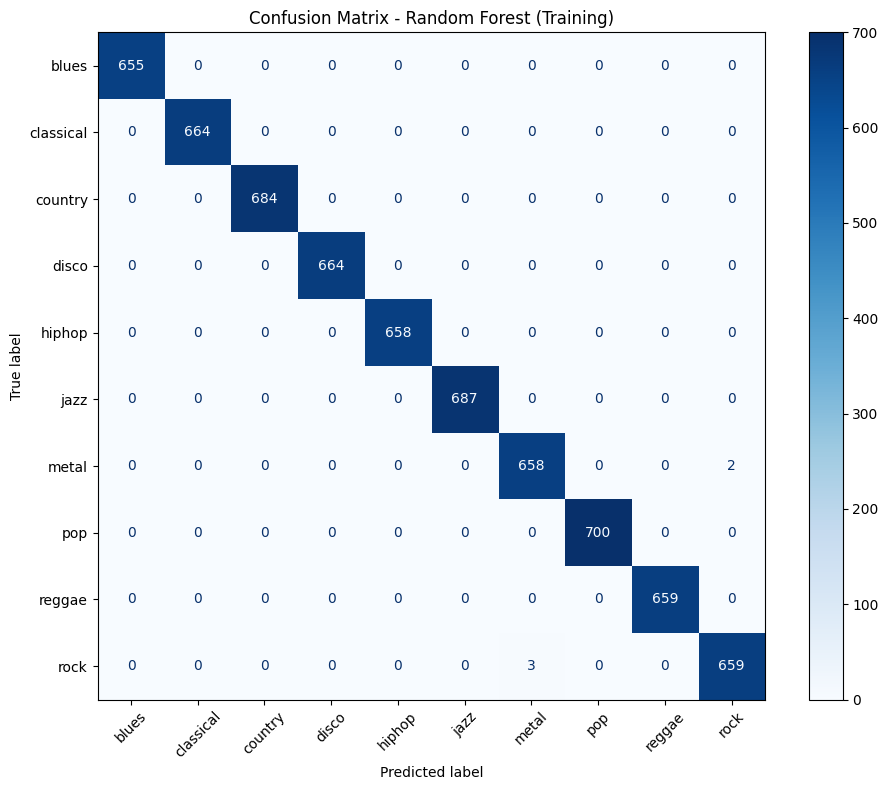


Classification Report (Test Set - Random Forest):
Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
              precision    recall  f1-score   support

       blues       0.90      0.83      0.86       345
   classical       0.91      0.95      0.93       334
     country       0.74      0.81      0.77       313
       disco       0.85      0.83      0.84       335
      hiphop       0.91      0.85      0.88       340
        jazz       0.80      0.89      0.85       313
       metal       0.89      0.95      0.92       340
         pop       0.89      0.91      0.90       300
      reggae       0.86      0.88      0.87       341
        rock       0.86      0.72      0.78       336

    accuracy                           0.86      3297
   macro avg       0.86      0.86      0.86      3297
weighted avg       0.86      0.86      0.86      3297



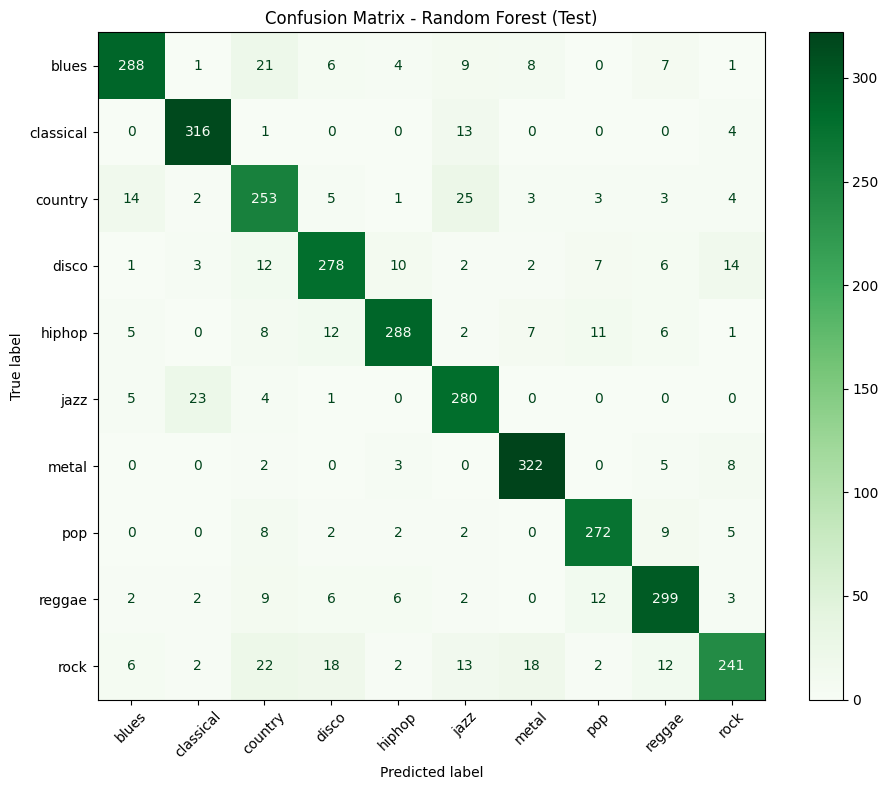

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define pipeline
pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Grid search
grid_rf = GridSearchCV(pipe, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(x_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_
y_train_pred = best_rf.predict(x_train)
y_test_pred = best_rf.predict(x_test)

# Evaluation on TRAINING set
print("\nClassification Report (Training Set - Random Forest):")
print(classification_report(y_train, y_train_pred, target_names=genres))

cm_train = confusion_matrix(y_train, y_train_pred)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=genres).plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest (Training)")
plt.tight_layout()
plt.show()

# Evaluation on TEST set
print("\nClassification Report (Test Set - Random Forest):")
print("Best Parameters:", grid_rf.best_params_)
print(classification_report(y_test, y_test_pred, target_names=genres))

cm_test = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=genres).plot(ax=ax, cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest (Test)")
plt.tight_layout()
plt.show()



#### RNN
To improve the performance of the RNN-based model for music genre classification, we applied hyperparameter optimization using Keras Tuner. The dataset consisted of MFCC sequences extracted from 3-second audio segments using the GTZAN dataset.

The tuning process included the following hyperparameters:

- Number of units in the two LSTM layers (lstm_units_1, lstm_units_2).

- Dropout rates after each LSTM and dense layer (dropout_1, dropout_2, dropout_3) to prevent overfitting.

- Number of units in the dense layer.

- Learning rate, to control the optimizer’s convergence.

The search space was explored using random search, with 10 trials and validation performance (val_accuracy) as the objective. The best model, identified through validation accuracy, was then evaluated on the test set. This approach enabled us to systematically explore architectural and training parameters that contribute to better generalization in sequence modeling tasks.

In [50]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_rnn_model(hp):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(130, 20)))

    # LSTM Layer 1
    model.add(LSTM(units=hp.Int("lstm_units_1", min_value=64, max_value=256, step=64), return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.5, step=0.1)))

    # LSTM Layer 2
    model.add(LSTM(units=hp.Int("lstm_units_2", min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_2", min_value=0.2, max_value=0.5, step=0.1)))

    # Dense Layer
    model.add(Dense(units=hp.Int("dense_units", min_value=32, max_value=128, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_3", min_value=0.2, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(len(np.unique(y)), activation='softmax'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("lr", values=[1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='rnn_tuning',
    project_name='music_genre_rnn'
)

tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32)

best_rnn_model = tuner.get_best_models(num_models=1)[0]
loss, acc = best_rnn_model.evaluate(X_test, y_test)
print(f"Best RNN Accuracy on Test Set: {acc:.4f}")


Trial 10 Complete [00h 04m 43s]
val_accuracy: 0.8446893692016602

Best val_accuracy So Far: 0.8522043824195862
Total elapsed time: 00h 44m 48s
63/63 [==============================] - 4s 17ms/step - loss: 0.4889 - accuracy: 0.8522
Best RNN Accuracy on Test Set: 0.8522


#### CNN
Convolutional Neural Network with Hyperparameter Tuning
To optimize the CNN architecture for music genre classification, we applied Keras Tuner to perform hyperparameter tuning. The model was trained on MFCC features extracted from segmented audio data and reshaped to 4D to match the input format expected by convolutional layers.

The hyperparameters included in the search space were:

- Number of filters in the convolutional layers (filters_1, filters_2, filters_3).

- Units in fully connected layers (dense_1, dense_2).

- Dropout rates after each dense layer to prevent overfitting.

- Learning rate for the Adam optimizer.

Using random search over 10 trials, the tuner selected the best configuration based on validation accuracy. The final CNN was evaluated on the test set, yielding insights into its generalization capability. This tuning strategy allowed us to balance model complexity with robustness and accuracy, ensuring optimal performance for multiclass audio classification tasks.

In [51]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_cnn_model(hp):
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(
        filters=hp.Choice("filters_1", values=[32, 64]),
        kernel_size=(2, 2),
        activation='relu',
        kernel_initializer='he_normal',
        input_shape=X_train.shape[1:]
    ))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(BatchNormalization())

    # Conv Block 2
    model.add(Conv2D(
        filters=hp.Choice("filters_2", values=[64, 128]),
        kernel_size=(2, 2),
        activation='relu',
        kernel_initializer='he_normal'
    ))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(BatchNormalization())

    # Conv Block 3
    model.add(Conv2D(
        filters=hp.Choice("filters_3", values=[128, 256]),
        kernel_size=(2, 2),
        activation='relu',
        kernel_initializer='he_normal'
    ))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(BatchNormalization())

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(
        hp.Choice("dense_1", values=[64, 128, 256]),
        activation='relu',
        kernel_initializer='he_normal'
    ))
    model.add(Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1)))

    model.add(Dense(
        hp.Choice("dense_2", values=[32, 64, 128]),
        activation='relu',
        kernel_initializer='he_normal'
    ))
    model.add(Dropout(hp.Float("dropout_2", 0.2, 0.5, step=0.1)))

    model.add(Dense(y_onehot.shape[1], activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='music_genre_cnn'
)

tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32)

best_cnn_model = tuner.get_best_models(num_models=1)[0]
loss, acc = best_cnn_model.evaluate(X_test, y_test)
print(f"Best CNN Accuracy on Test Set: {acc:.4f}")


Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.7800601124763489

Best val_accuracy So Far: 0.8016031980514526
Total elapsed time: 00h 08m 26s
63/63 [==============================] - 0s 3ms/step - loss: 0.8721 - accuracy: 0.8016
Best CNN Accuracy on Test Set: 0.8016


### Step 7: Save Models (Pickle Files)

In [52]:
best_cnn_model.save("best_cnn_model.h5")

In [53]:
best_rnn_model.save("best_Rnn_model.h5")

### Step 8: Web Application (Flask or Streamlit)